In [3]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Preprocessing

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'data/images_train_test_val/train'
output_dir = 'data/processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Check Image Corruption

In [4]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


Train/Test Split

In [5]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [6]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = create_model()

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-17 22:23:20.734391: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-17 22:23:20.734438: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-17 22:23:20.734453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-17 22:23:20.734691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-17 22:23:20.734724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

Model Creation

In [7]:
# Define a checkpoint callback
checkpoint = ModelCheckpoint(
    'models/best_CNN_model.keras',  
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]  # include both callbacks here
)

Epoch 1/20


2024-07-17 22:23:33.897540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.0642 - loss: 3.0579
Epoch 1: val_accuracy improved from -inf to 0.08476, saving model to models/best_CNN_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 64s 526ms/step - accuracy: 0.0644 - loss: 3.0570 - val_accuracy: 0.0848 - val_loss: 2.8627
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.1349 - loss: 2.7787
Epoch 2: val_accuracy improved from 0.08476 to 0.21095, saving model to models/best_CNN_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 625ms/step - accuracy: 0.1350 - loss: 2.7782 - val_accuracy: 0.2110 - val_loss: 2.5303
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.2046 - loss: 2.5545
Epoch 3: val_accuracy improved from 0.21095 to 0.25667, saving model to models/best_CNN_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 85s 714ms/step - accuracy: 0.2047 - loss: 2.5542 - val_accuracy: 0.2567 - val_loss: 2.3484
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.2474 - loss: 2.3955
Ep

In [10]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 370ms/step - accuracy: 0.6656 - loss: 1.1372
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.5194 - loss: 1.5401
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - accuracy: 0.5319 - loss: 1.5181
Train accuracy: 0.6597, Validation accuracy: 0.5271, Test accuracy: 0.5238


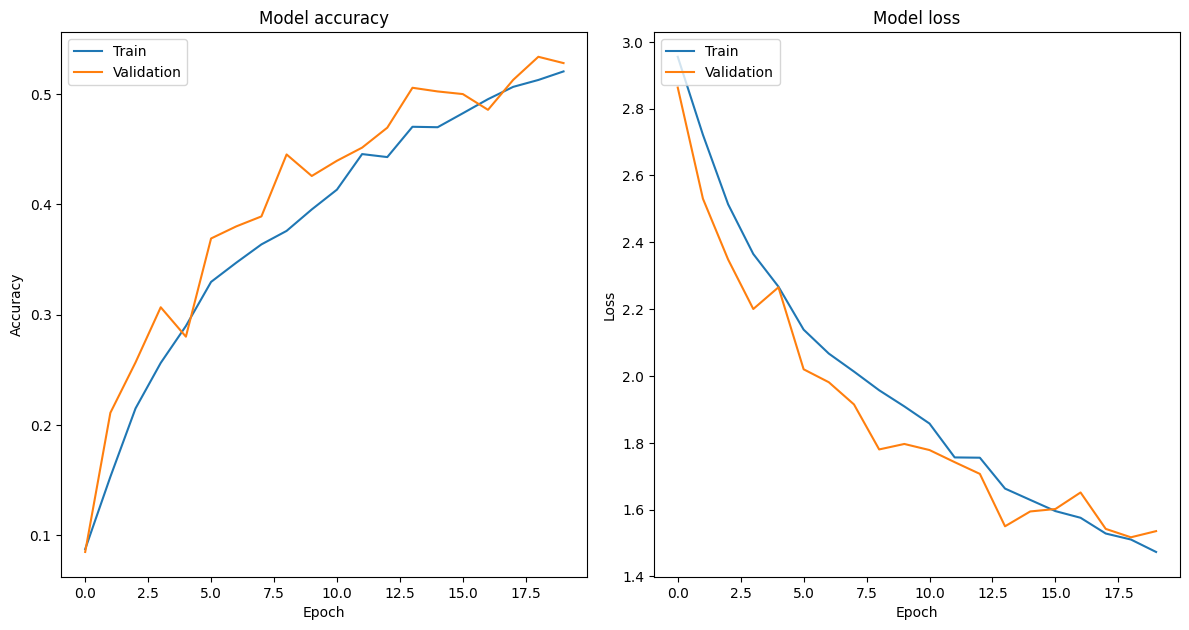

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()